# DATA IMPORT

In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pylab as pl
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from functools import reduce
import sqlite3

In [ ]:
combined = pd.read_csv('00 combined_filtered.csv')
# mens = pd.read_csv('01 men_filtered.csv')
# womens = pd.read_csv('01 women_filtered.csv')

In [ ]:
renamed = ['Player', 'Pos', 'Squad', 'Gender', 'League', 'Gen+League', 'Season',
       'Age', 'Born', 'Nation', 'ATT', 'MID', 'DEF', 'MP', 'Min', 'Starts', 'Ast', 'G+A/90',
       'G+A-PK/90',  'G-PK/90', 'Gls/90', 'Ast/90', 'CrdR', 'CrdY',
       'Fls', 'Gls', 'OG', 'PK','PKatt', 'G/SoT','SoT', 'SoT/90', 'Tkl+Int']
combined.columns = renamed
# mens.columns = renamed
# womens.columns = renamed

In [ ]:
total_matches = combined.groupby('Gen+League').agg({'MP': 'max'})
total_matches.rename(columns ={'MP': 'Total_MP'}, inplace = True)
top_fls = combined.groupby('Gen+League').agg({'Fls': 'max'})
top_fls.rename(columns ={'Fls': 'Top_Fls'}, inplace = True)
top_tkl = combined.groupby('Gen+League').agg({'Tkl+Int': 'max'})
top_tkl.rename(columns ={'Tkl+Int': 'Top_Tkl'}, inplace = True)
combined = combined.merge(total_matches, on = "Gen+League", how = 'left')
combined = combined.merge(top_fls, on = "Gen+League", how = 'left')
combined = combined.merge(top_tkl, on = "Gen+League", how = 'left')


In [ ]:
def distrib(df, attributes, category):
    temp_list = attributes.copy()
    temp_list.append(category)
    a = df[temp_list].groupby(category)
    outdict = {}
    for name, group in a:
        outdict[name] = {"averages":group.mean(axis=0), "std dev":group.std(axis=0)}
        group.hist(figsize=(50, 30))
        plt.suptitle(name, fontsize=40)
    return outdict

def by_stat(summary, statlist):
    statdict = {}
    for stat in summary["A-League"]['averages'].keys():
#         statlist.append(stat)
        statdict[stat] = {}
    
    for stat in statlist:
        for lg in summary:
            mean = summary[lg]['averages'][stat]
            stddev = summary[lg]['std dev'][stat]
            #print(lg, stat, mean, stddev)
            statdict[stat][lg] = (mean,stddev)
    #print(statdict)
    return statdict

def normalize(df, attribute, group):
    col_name = 'norm ' + attribute
    a = df.groupby(group)
    aDict = {}
    for name, g in a:
        mu = g[attribute].mean()
        sigma = g[attribute].std()
        aDict[name] = [mu, sigma]
    df1 = pd.DataFrame(aDict).transpose()
    df1.reset_index(level=0, inplace=True)
    df1.columns = [group, 'mean', 'stdev']
    df = df.merge(df1, how = 'left', on = group)
    df[col_name] = (df[attribute] - df['mean'])/df['stdev']
    df.drop('mean', axis=1 , inplace = True)
    df.drop('stdev', axis=1 , inplace = True)
    return df

def log_scale(df, attribute):
    col_name = 'log ' + attribute
    df[col_name] = np.log(df[[attribute]].replace(0, np.nan)).fillna(0)
    return df

def rank_order(df, attribute, group):
    col_name = 'rank ' + attribute
    df[col_name] = df.groupby(group)[attribute].rank("dense", pct = True)
    return df


In [ ]:
# Get % for Minutes and Matches Played
combined['%MP'] = combined['MP']/combined['Total_MP']
combined['%Starts'] = combined['Starts']/combined['Total_MP']
combined['%Min'] = combined['Min']/(combined['Total_MP']*90)

# Z-score normalizing
combined = normalize(combined, 'Age', 'Gen+League')

# log scaling
combined = log_scale(combined, 'CrdY')
combined = log_scale(combined, 'CrdR')

# rank orders
combined = rank_order(combined,"MP", 'Gen+League')
combined = rank_order(combined,"Gls", 'Gen+League')
combined = rank_order(combined,"Ast", 'Gen+League')
combined = rank_order(combined,"PK", 'Gen+League')
combined = rank_order(combined,"SoT", 'Gen+League')
combined = rank_order(combined,"CrdY", 'Gen+League')
combined = rank_order(combined,"CrdR", 'Gen+League')

# percentile scaled
combined['Fls/Top'] = combined['Fls']/combined['Top_Fls']
combined['Tkl/Top'] = combined['Tkl+Int']/combined['Top_Tkl']


combined.columns

Index(['Player', 'Pos', 'Squad', 'Gender', 'League', 'Gen+League', 'Season',
       'Age', 'Born', 'Nation', 'ATT', 'MID', 'DEF', 'MP', 'Min', 'Starts',
       'Ast', 'G+A/90', 'G+A-PK/90', 'G-PK/90', 'Gls/90', 'Ast/90', 'CrdR',
       'CrdY', 'Fls', 'Gls', 'OG', 'PK', 'PKatt', 'G/SoT', 'SoT', 'SoT/90',
       'Tkl+Int', 'Total_MP', 'Top_Fls', 'Top_Tkl', '%MP', '%Starts', '%Min',
       'norm Age', 'log CrdY', 'log CrdR', 'rank MP', 'rank Gls', 'rank Ast',
       'rank PK', 'rank SoT', 'rank CrdY', 'rank CrdR', 'Fls/Top', 'Tkl/Top'],
      dtype='object')

# CLUSTERING


In [ ]:
#RUN CLUSTERING ON SELETED ATTRIBUTES
col1 = ['Age', '%MP', '%Min', '%Starts', 
               'G+A/90', 'G+A-PK/90', 'G-PK/90', 'Gls/90', 'Ast/90', 'SoT/90',
               'Tkl+Int', 'OG', 'Fls', 'PK', 'PKatt', 'G/SoT', 
               'norm Age', 'rank SoT', 'rank CrdY', 'rank CrdR', 'rank MP', 'rank Gls', 'rank Ast', 
               'Fls/Top', 'Tkl/Top']

test1 = combined[col1]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(test1.fillna(0))

kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 0)
kmeans.fit(scaled_features)
clusters1 = kmeans.labels_

## Cluster Analysis

In [ ]:
#SILHOUETTE COEFFICIENT
print(f'Silhouette Score(n=5): {silhouette_score(scaled_features, clusters1)}')

Silhouette Score(n=5): 0.2142087992743124


In [ ]:
# SUMMARY OF CLUSTERS
result1 = combined.copy()
result1['cluster'] = clusters1
counts = result1.groupby('cluster').agg({'Player': 'count'})
summary = result1.groupby('cluster').agg('mean')
summary = summary.merge(counts, on= 'cluster')
summary.rename(columns={"Player": "Count"}, inplace = True)
summary = summary.round(decimals=2)
summary[['Count', 'Age', 'ATT', 'MID', 'DEF','%Min', '%MP', '%Starts', 'SoT/90', 'G+A/90', 'Tkl+Int','Fls', 'CrdY', 'CrdR']]

,Count,Age,ATT,MID,DEF,%Min,%MP,%Starts,SoT/90,G+A/90,Tkl+Int,Fls,CrdY,CrdR
cluster,,,,,,,,,,,,,,
0,39024,24.79,0.22,0.52,0.49,0.21,0.31,0.20,0.31,0.07,1.07,9.87,1.48,0.10
1,11261,25.42,0.68,0.63,0.06,0.64,0.79,0.66,0.97,0.49,1.53,34.56,3.63,0.19
2,3235,26.01,0.14,0.51,0.58,0.65,0.74,0.66,0.25,0.14,70.43,28.53,4.84,0.25
3,13858,24.68,0.69,0.52,0.09,0.22,0.38,0.21,0.99,0.53,0.94,11.63,1.30,0.08
4,3052,27.10,0.74,0.48,0.07,0.70,0.80,0.72,1.23,0.64,2.69,38.05,4.14,0.23
5,30120,26.32,0.10,0.52,0.62,0.65,0.73,0.66,0.26,0.11,0.28,33.60,4.90,0.32


## Finding Similar Players

Finds the other players most similar to specified player. Can look for other players in a specific league or gender

In [ ]:
def find_similar(name, df, league = None, gender = None):
  combined['League'].unique()
  df[df['Player']==name]

  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(df[col1].fillna(0))

  coordinates = pd.DataFrame(scaled_features.copy())
  coordinates['Player'] = df['Player']
  coordinates['League'] = df['League']
  coordinates['Gender'] = df['Gender']


  player = coordinates[coordinates['Player'] == name]
  player.drop(['Player',  'League', 'Gender'], axis = 1, inplace = True)
  player = np.array(player)

  others = coordinates[coordinates['Player'] != name]
  results_df = combined[combined['Player'] != name]

  if league != None:
    others = others[others['League'] == league]
    results_df = results_df[results_df['League'] == league]
  if gender != None:
    others = others[others['Gender'] == gender]
    results_df = results_df[results_df['Gender'] == gender]
  others = others.drop(['Player','League', 'Gender'], axis = 1)
  others = np.array(others)

  indices = pairwise_distances_argmin_min(player, others)
  results_df = results_df.iloc[indices[0]]

  results_df = results_df[['Player', 'Pos', 'Squad', 'Gender', 'League', 'Season',
       'Age', 'Min', 'Gls/90', 'Ast/90',
       'SoT/90',
       'Fls', 'Tkl+Int']]
  return results_df



In [ ]:
find_similar('Lionel Messi', combined)
# result1[result1['Player'] == 'Lionel Messi']

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Player,Pos,Squad,Gender,League,Season,Age,Min,Gls/90,Ast/90,SoT/90,Fls,Tkl+Int
66129,Jamar Beasley,FW,Chicago,M,MLS,2001,21.0,727.0,0.50,3.0,2.10,18.0,0.0
24571,Siem de Jong,"FW,MF",Ajax,M,Dutch Eredivise,2009,20.0,1500.0,0.60,3.0,1.38,25.0,0.0
77868,Wayne Rooney,"FW,MF",Manchester Utd,M,Premier League Men,2010,24.0,2225.0,0.44,11.0,1.62,25.0,0.0
77963,Sergio Agüero,FW,Manchester City,M,Premier League Men,2011,23.0,2575.0,0.80,9.0,1.82,21.0,0.0
23804,Klaas-Jan Huntelaar,FW,Ajax,M,Dutch Eredivise,2007,23.0,3056.0,1.00,8.0,2.09,40.0,0.0
47364,Luis Suárez,FW,Barcelona,M,La Liga Men,2015,28.0,3150.0,1.14,16.0,2.00,41.0,0.0
46893,Cristiano Ronaldo,"FW,MF",Real Madrid,M,La Liga Men,2014,29.0,3100.0,1.39,16.0,3.08,27.0,0.0
63590,Zlatan Ibrahimović,FW,Paris S-G,M,Ligue 1 Men,2015,33.0,2549.0,1.34,13.0,2.86,27.0,0.0
47340,Cristiano Ronaldo,"FW,MF",Real Madrid,M,La Liga Men,2015,30.0,3182.0,0.99,11.0,3.00,21.0,0.0
63590,Zlatan Ibrahimović,FW,Paris S-G,M,Ligue 1 Men,2015,33.0,2549.0,1.34,13.0,2.86,27.0,0.0


In [ ]:
find_similar('Megan Rapinoe', combined)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Player,Pos,Squad,Gender,League,Season,Age,Min,Gls/90,Ast/90,SoT/90,Fls,Tkl+Int
850,Aya Miyama,MF,jp Japan,W,FIFA World Cup,2011,26.0,599.0,0.30,5.0,0.60,NaN,0.0
2440,Lori Chalupny,MF,Chicago,W,NWSL,2013,29.0,1500.0,0.30,4.0,1.20,33.0,0.0
64832,Edinson Cavani,FW,Paris S-G,M,Ligue 1 Men,2018,31.0,1671.0,0.97,5.0,0.92,13.0,18.0
84705,Fatih Tekke,FW,Zenit,M,Russian Premier League,2008,30.0,1096.0,0.66,1.0,1.64,25.0,0.0
3183,Karen Carney,"MF,FW",Chelsea,W,Super League,2018,29.0,617.0,0.44,4.0,NaN,NaN,0.0
2781,Alex Morgan,FW,Portland,W,NWSL,2015,25.0,285.0,0.32,2.0,2.21,0.0,0.0


In [ ]:
find_similar('Megan Rapinoe', combined, gender= 'M')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Player,Pos,Squad,Gender,League,Season,Age,Min,Gls/90,Ast/90,SoT/90,Fls,Tkl+Int
70676,Kwadwo Poku,"FW,MF",NYCFC,M,MLS,2015.0,22.0,995.0,0.36,6.0,0.90,18.0,0.0
4638,Youssouf Hersi,MF,W Sydney,M,A-League,2012.0,29.0,1630.0,0.28,6.0,0.99,37.0,0.0
81438,Sergio Agüero,FW,Manchester City,M,Premier League Men,2019.0,31.0,1452.0,0.99,3.0,1.55,9.0,9.0
84705,Fatih Tekke,FW,Zenit,M,Russian Premier League,2008.0,30.0,1096.0,0.66,1.0,1.64,25.0,0.0
55747,Edwin Cardona,MF,Pachuca,M,Liga MX,2018.0,25.0,1321.0,0.41,9.0,NaN,NaN,0.0
71552,KrisztiÃ¡n NÃ©meth,"FW,MF",New England,M,MLS,2017.0,28.0,177.0,0.51,1.0,1.53,3.0,0.0


In [ ]:
find_similar('Edinson Cavani', combined)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Player,Pos,Squad,Gender,League,Season,Age,Min,Gls/90,Ast/90,SoT/90,Fls,Tkl+Int
53541,Mauro Boselli,FW,LeÃ³n,M,Liga MX,2013,28.0,2003.0,0.63,2.0,1.62,26.0,0.0
69157,Kenny Cooper,FW,NY Red Bulls,M,MLS,2012,27.0,2504.0,0.65,2.0,1.65,37.0,0.0
77551,Dimitar Berbatov,FW,Manchester Utd,M,Premier League Men,2010,29.0,2208.0,0.82,4.0,1.87,35.0,0.0
44030,Diego Forlán,"FW,MF",Atlético Madrid,M,La Liga Men,2008,29.0,2807.0,1.03,5.0,2.18,21.0,0.0
19160,Pierre-Emerick Aubameyang,FW,Dortmund,M,Bundesliga Men,2015,26.0,2467.0,0.91,5.0,1.97,29.0,0.0
80585,Sergio Agüero,FW,Manchester City,M,Premier League Men,2017,29.0,1963.0,0.96,6.0,1.74,10.0,16.0
7389,Ermin Šiljak,FW,Mouscron,M,Belgian First Division A,2005,32.0,645.0,0.56,1.0,1.26,NaN,0.0
71850,Jeremy Ebobisse,FW,Portland,M,MLS,2018,20.0,450.0,0.40,0.0,0.60,12.0,3.0
92209,Michele Paolucci,"FW,MF",Ascoli,M,Serie A Men,2006,20.0,1851.0,0.29,0.0,0.92,68.0,0.0
31572,Dexter Blackstock,FW,QPR,M,EFL Championship,2006,20.0,3092.0,0.38,3.0,1.25,73.0,0.0


# PCA

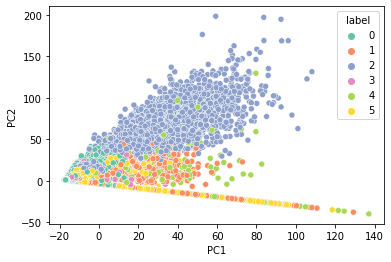

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(test1.fillna(0))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
principalDf['label'] = kmeans.labels_

sns.scatterplot(x=principalDf.PC1, y=principalDf.PC2, hue=principalDf.label, 
                palette="Set2")

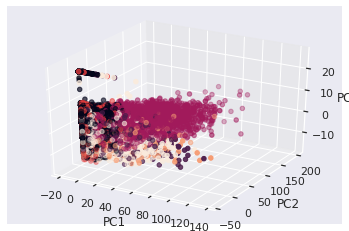

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(test1.fillna(0))

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3'])

x = principalDf['PC1']
y = principalDf['PC2']
z = principalDf['PC3']

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.scatter(x, y, z, c=result1['clusters'])

plt.show()


In [ ]:
output = result1[['clusters','Player', 'Pos', 'Squad', 'Gender', 'League', 'Season',
       'Age', 'Min', 'Gls/90', 'Ast/90',
       'SoT/90',
       'Fls', 'Tkl+Int']]

output.to_csv("cluster_output.csv")

# VISUALIZE PLAYER COMPARISON

In [ ]:
# Get Averages of all Players
df = result1[['clusters','Player', 'Pos', 'Squad', 'Gender', 'League', 'Season',
       'Born', 'Min', 'Gls/90', 'Ast/90',
       'SoT/90',
       'Fls', 'Tkl+Int']]
df1 = output.groupby('Player').agg(lambda x: set(x))
df2 = output.groupby('Player').agg({'Born': 'max', 'Season': ['max', 'min'], 'Min': 'mean', 'Gls/90': 'mean', 'Ast/90': 'mean', 'SoT/90': 'mean', 'Fls': 'mean', 'Tkl+Int': 'mean'})
print(df1.columns)
df1 = df1[['clusters', 'Pos', 'Squad', 'Gender', 'League']]
final = df1.merge(df2, how = 'left', on = 'Player')
final

# Compare Players
def compare(player1, player2):
  p1 = final[final['Player']==player1]
  p2 = final[final['Player']==player2]
  return pd.concat(p1, p2)


NameError: ignored